In [1]:
# Dependencies 

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pk
from sklearn.naive_bayes import GaussianNB
from scipy.special import comb
import multiprocessing as mp

In [2]:
# Some paths
rootPath = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPath = 'pkl/'

# Our color code for calls
callColor = {'Be': (0/255.0, 230/255.0, 255/255.0), 'LT': (0/255.0, 95/255.0, 255/255.0), 'Tu': (255/255.0, 200/255.0, 65/255.0), 'Th': (255/255.0, 150/255.0, 40/255.0), 
             'Di': (255/255.0, 105/255.0, 15/255.0), 'Ag': (255/255.0, 0/255.0, 0/255.0), 'Wh': (255/255.0, 180/255.0, 255/255.0), 'Ne': (255/255.0, 100/255.0, 255/255.0),
             'Te': (140/255.0, 100/255.0, 185/255.0), 'DC': (100/255.0, 50/255.0, 200/255.0), 'So': (0/255.0, 0/255.0, 0/255.0)}

# Call names are in alphabetical order (to check...)

callNames = ['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'So', 'Te', 'Th', 'Wh']

In [6]:


# First load the data

numUnits = [1, 2, 3, 5, 10, 20]
argList = []
pcc = []
confMat = []

for nUnit in numUnits:
    inPath = rootPath+ pklPath + 'JulieDataBase%dGoodUnitPC.pkl' % nUnit
    fileIn = open(inPath,"rb")
    argList.append(pk.load(fileIn))
    confMat.append(pk.load(fileIn))
    pcc.append(pk.load(fileIn))
    fileIn.close()


In [9]:
def info_matrix(conf_matrix):

# Calculates the mutual information from a confusion matrix.
# This code assumes that the rows are the actual categories and that they are equally probable
# This mutual information is not corrected for low probabilities.

    ncat = conf_matrix.shape[0]
    prob_matrix = np.copy(conf_matrix)

    for i in range(ncat):
        if (np.sum(conf_matrix[i,:]) < 0.9999 or np.sum(conf_matrix[i,:]) >  1.0001):
            print('Error: Row', i, 'does not sum to 1')
            return 0.0
    
    prob_matrix /= ncat

        

    # Check for sum = 1
    sump = np.sum(prob_matrix)
    if ( sump < 0.9999 or sump > 1.0001):
        print('Error in info_matrix: input matrix sums to %f' % sump)
        return 0.0


    prob_matrix_for_entropy = np.copy(prob_matrix)
    prob_matrix_for_entropy[prob_matrix ==0] = 1    # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    tot_ent = np.sum(-prob_matrix_for_entropy*np.log2(prob_matrix_for_entropy))

    row_prob = np.sum(prob_matrix, axis=0)
    row_prob[row_prob == 0] = 1  # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    row_ent = np.sum(-row_prob*np.log2(row_prob))

    col_prob = np.sum(prob_matrix, axis=1)
    col_prob[col_prob == 0] = 1  # Set 0 to 1 to insure that xlogx goes to zero as x goes to zero
    col_ent = np.sum(-col_prob*np.log2(col_prob));

    mi = row_ent + col_ent - tot_ent;

    return mi

In [10]:
# Calculate values to plot - take the mean and the top 10%

topPercent = 5.0
infoMean = []
pccMean = []
pccMax = []
argMax = []
for i, nUnit in enumerate(numUnits):
    # Mean values
    infoMean.append(info_matrix(confMat[i]))
    pccMean.append(np.mean(pcc[i]))
    
    # Max values (averaged over the topPercent)
    indSort = np.argsort(pcc[i])
    ls = len(indSort)
    ns = int(ls*topPercent/100.0)
    indGood = indSort[-ns:-1]
    pccMax.append(np.mean(pcc[i][indGood]))
    argMax.append(indGood)

    

In [3]:
# Load up data base to recalculate max values.

# Load the data base
outPath = rootPath+'JulieDataBase.pkl'
fileIn = open(outPath,"rb")
dfDataBase = pk.load(fileIn)
pcKDE = pk.load(fileIn)
fileIn.close()

In [11]:
# Julie's data was ran without whines

dfDataBaseNW = dfDataBase[dfDataBase['call'] != 'Wh']
# Number of Calls
callNames = np.unique(dfDataBaseNW['call'])
ncalls = callNames.shape[0]

In [22]:
def naiveBayes(unitChoice, plotFlg = False, usingAllCombos = False, code='PC', verbose = False):
    # naiveBayes runs a guassian classifier for call types using the responses in the units in the list unitChoice
    # This is the same code as in decodingCallTypeNaiveBayesPart2 and should be synced...
    
    # Number of units
    numUnits = len(unitChoice)
    
    # Number of PCs (for PC code)
    nPCs = dfDataBaseNW['PC'][0].shape[0]
    
    # Find the unique stims played for the chosen unit
    unitIndexDict = dict()
    unitIndexLen = []
    stimList = []
    for unit in unitChoice:   
        unitIndex = dfDataBaseNW.index[dfDataBaseNW['site']+'_'+ dfDataBaseNW['unit'] == unit]
        unitIndexDict[unit] = unitIndex
        unitIndexLen.append(len(unitIndex))
        stimList.extend(list(dfDataBaseNW['stim'][unitIndex].array))
    
    stimNames = np.unique(stimList)
    
    # Generate ensemble responses  for the units in unitChoice

    # Training Trials
    rowListList = []
    totTrials = 0

    # Testing Trials
    rowListListTest = []
    totTestTrials = 0

    for stim in stimNames:
        goodStim = 2    # This means that we have at least two trials for each stim for all units
        
        # Check to see if we have enough trials for all units for this stim
        for unit in unitChoice:
            unitIndex = unitIndexDict[unit]
            unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
            if len(unitIndexStim) == 0:
                goodStim = 0
                print('Stim ', stim, 'has no response for unit', unit, '. Skipping')
                break
            elif len(unitIndexStim) == 1:
                goodStim = 1
            
        # If so continue
        if goodStim > 0 :
            rowList2Cat = []
            rowList2CatLen = []
            for unit in unitChoice:
                unitIndex = unitIndexDict[unit]
                unitIndexStim = [ind for ind in unitIndex if dfDataBaseNW['stim'][ind] == stim]
                rowList2Cat.append(unitIndexStim)
                rowList2CatLen.append(len(unitIndexStim))
            
            if goodStim > 1 :  # Use one of the responses for the test set
                listTest = []
                for iunit, unit in enumerate(unitChoice):
                    rowchosen = np.random.choice(rowList2Cat[iunit], 1, replace=False)
                    listTest.append(rowchosen[0])
                    rowList2Cat[iunit].remove(rowchosen)
                    rowList2CatLen[iunit] = len(rowList2Cat[iunit])
                rowListListTest.append(listTest)
                totTestTrials +=1
            
            if usingAllCombos:
                numSamp = np.prod(rowList2CatLen)
                totTrials += numSamp
            
                list_of_lists = []

                indUnit = np.zeros((numUnits,), dtype=int)
                indUnit[0] = -1
            
                for i in range(numSamp):
                    for iunit, unit in enumerate(unitChoice):
                        indUnit[iunit] += 1
                        if (indUnit[iunit] >= len(rowList2Cat[iunit]) ):
                            indUnit[iunit] = 0
                        else: 
                            break
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        trialList.append(rowList2Cat[iunit][indUnit[iunit]])
                
                    list_of_lists.append(trialList)
            else:
                numSamp = np.max(rowList2CatLen)
                totTrials += numSamp
                    
                list_of_lists = []
                for i in range(numSamp):
                    trialList = []
                    for iunit, unit in enumerate(unitChoice):
                        if i < len(rowList2Cat[iunit]):
                            trialList.append(rowList2Cat[iunit][i])
                        else:
                            trialList.append(np.random.choice(rowList2Cat[iunit], 1, replace=False)[0])
                    list_of_lists.append(trialList)
        
            rowListList.extend(list_of_lists)

    if verbose:        
        print('Total number of trials:', totTrials)
        print('Total number of test trials:', totTestTrials)
    
    # Make X (neural code), Y (call type)
    if code == 'z':
        Xfit = np.zeros((totTrials, numUnits*1))
        Xtest = np.zeros((totTestTrials, numUnits*1))
    elif code == 'PC':
        Xfit = np.zeros((totTrials, numUnits*(1+nPCs)))
        Xtest = np.zeros((totTestTrials, numUnits*(1+nPCs)))
        
    Yfit = []
    for irow,rowList in enumerate(rowListList):
        if code == 'z':
            Xfit[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xfit[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
            
        Yfit.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    Yfit = np.array(Yfit)

    
    Ytest = []
    for irow,rowList in enumerate(rowListListTest):
        if code == 'z':
            Xtest[irow,:] = dfDataBaseNW['z'][rowList].array
        elif code == 'PC':
            Xtest[irow,:] = np.hstack([np.hstack((dfDataBaseNW['z'][ind], dfDataBaseNW['PC'][ind])) for ind in rowList])
        Ytest.append(np.unique(dfDataBaseNW['call'][rowList].array)[0])
    
    Ytest = np.array(Ytest)
    
    
    # Fit and test the classifier clf
    nClasses = len(np.unique(Yfit))

    clf = GaussianNB(priors=np.ones((nClasses,))/nClasses)
    clf.fit(Xfit,Yfit)

    probTest = clf.predict_proba(Xtest)

    # Make a confusion matrix
    confMat = np.zeros((nClasses,nClasses))
    testsPerClass = np.zeros((nClasses,))

    for i,y in enumerate(Ytest):
        classID = np.argwhere(clf.classes_ == y)
        testsPerClass[classID] += 1    
        confMat[classID,:] += probTest[i]
    
    # The confusion matrix is not normalized so that we can average it correctly later on.. 
    #for i in range(nClasses):
    #    confMat[i,:] /= testsPerClass[i]
    
    # Print percent correct classification by taking average of diagonal of confusion matrix.
    sumCorrect = np.trace(confMat)
    sumTest = np.sum(testsPerClass)
    pcc = 100.0*(sumCorrect/sumTest)
    
    if verbose:
        print('PCC %.0f %%' % (pcc))
    
    if plotFlg:
        # Normalize confMat for display
        confMatNorm = np.zeros((nClasses,nClasses))
        for i in range(nClasses):
            if testsPerClass[i] > 0 :
                confMatNorm[i,:] = confMat[i,:]/testsPerClass[i]
                
        # Display comfusion matrix
        cmap='viridis'
        fig, ax = plt.subplots()
        im_ = ax.imshow(confMatNorm*100.0, interpolation='nearest', cmap=cmap)

        fig.colorbar(im_, ax=ax)
        ax.set(xticks=np.arange(nClasses),
               yticks=np.arange(nClasses),
               xticklabels=clf.classes_,
               yticklabels=clf.classes_,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='PPC %.0f %%' % (pcc))
    
    return pcc, confMat, testsPerClass




In [23]:
callNames

array(['Ag', 'Be', 'DC', 'Di', 'LT', 'Ne', 'So', 'Te', 'Th'], dtype=object)

In [24]:
# Generate confusion matrices for max performance.  These could be saved in decodingCallTypeNaiveBayesPart2

pccMaxV2 = []
confMatMax = []
poolSize = 15

for iu, nUnit in enumerate(numUnits):   
    if __name__ == '__main__':              
        with mp.Pool(poolSize) as p:
            results = p.map(naiveBayes, [argList[iu][ind] for ind in argMax[iu]])
        
        pccTemp = np.zeros(len(results))
        confMatTot = np.zeros((ncalls,ncalls))
        confMatCount = 0
        for i, res in enumerate(results):
            pccTemp[i] = res[0]
            confMatTemp = res[1]
            testsPerClass = res[2]
            if (confMatTemp.shape == (ncalls,ncalls) ) :
                confMatTot = np.add(confMatTot, confMatTemp)
                confMatCount += testsPerClass

        # Normalize the confusion matrix. 
        for ic in range(ncalls):
            if confMatCount[ic] > 0:
                confMatTot[ic,:] = confMatTot[ic,:]/confMatCount[ic]
    
        pccMaxV2.append(np.mean(pccTemp))
        confMatMax.append(confMatTot)

In [25]:
ncalls

9

In [26]:
confMatCount

array([ 674.,  790., 1066.,  495.,  526.,  924., 1784., 1188.,  464.])

In [27]:
infoMax = []
for i, nUnit in enumerate(numUnits):
    # Mean values
    infoMax.append(info_matrix(confMatMax[i]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


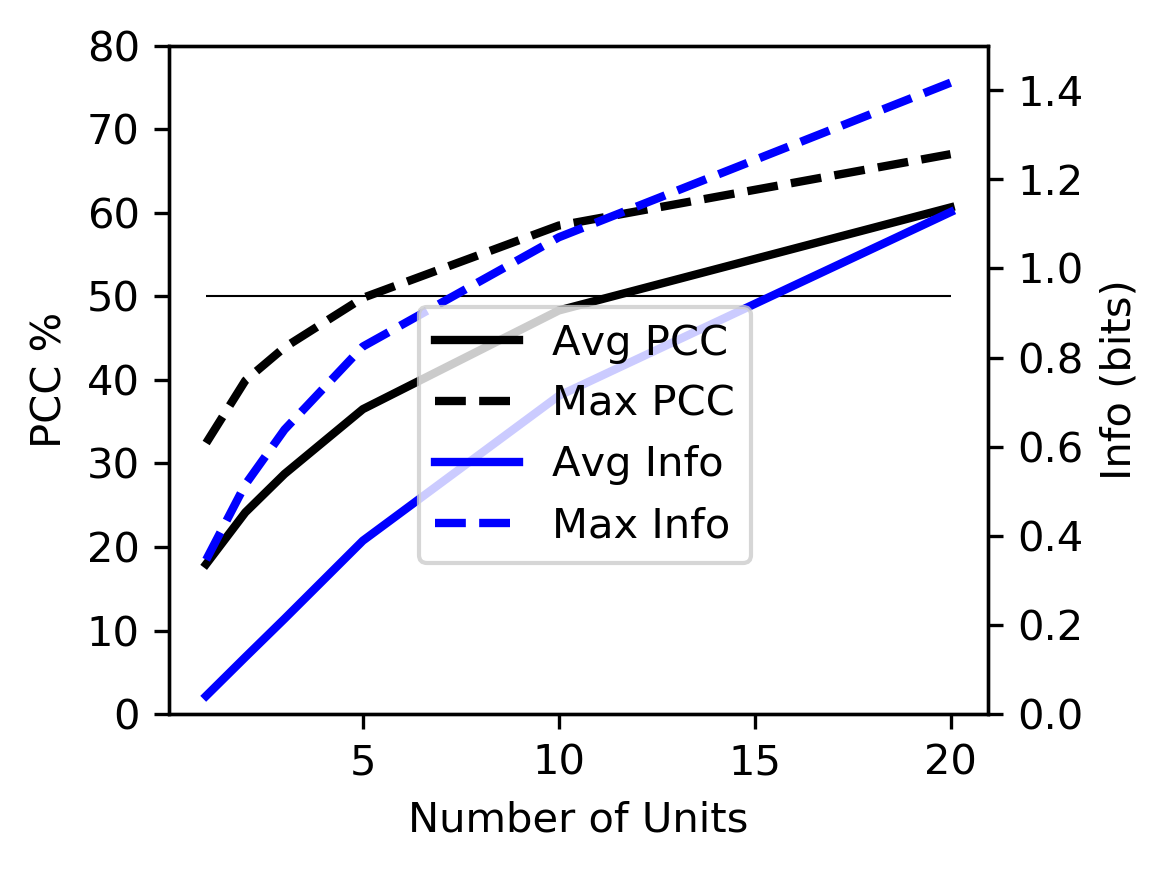

In [35]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('PCC %')
ax1.plot(numUnits, pccMean, color='black', linestyle='-', linewidth=2, label='Avg PCC')
ax1.plot(numUnits, pccMaxV2, color='black', linestyle='--', linewidth=2, label='Max PCC')
ax1.hlines(50.0, 1, 20, colors='black', linestyles='-', linewidth=0.5)
ax1.set_ylim((0,80))


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Info (bits)')  # we already handled the x-label with ax1
ax2.plot(numUnits, infoMean, color='blue', linestyle='-', linewidth=2, label='Avg Info')
ax2.plot(numUnits, infoMax, color='blue', linestyle='--', linewidth=2, label='Max Info')
ax2.set_ylim((0,1.5))


fig.tight_layout()
fig.legend(loc='center')

plt.savefig('/Users/frederictheunissen/Desktop/InfovsUnitsJulie.eps')

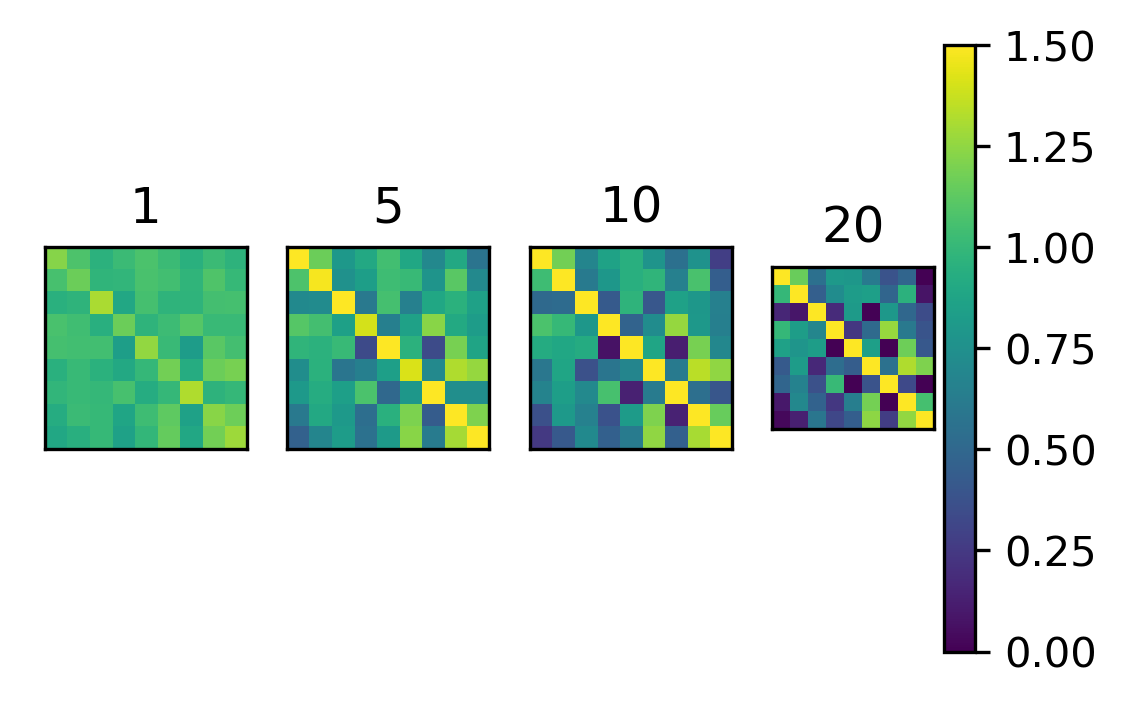

In [37]:
indToPlot = [0, 3, 4, 5]
fig = plt.figure(figsize=(4,8), dpi=300)
axes = fig.subplots( nrows = 1, ncols = len(indToPlot))
cmap='viridis'
ncalls = confMat[0].shape[0]

for i, ind in enumerate(indToPlot):    
    ax = axes[i]
    #im_ = ax.imshow(confMat[ind]*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=10, vmax = 50)
    im_ = ax.imshow(np.log10(confMat[ind]*100.0), interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=0, vmax = 1.5)

    ax.set(
               xticks=[],
               yticks=[],
               ylim = (ncalls-0.5, -0.5),
               xticklabels=[],
               yticklabels=[],
               # ylabel="Actual Call Type",
               # xlabel="Predicted Call Type",
               title='%d' % numUnits[ind] )

fig.colorbar(im_, ax=ax)
plt.savefig('/Users/frederictheunissen/Desktop/confMatAllUnitGoodPCLogwScaleJulie.eps')

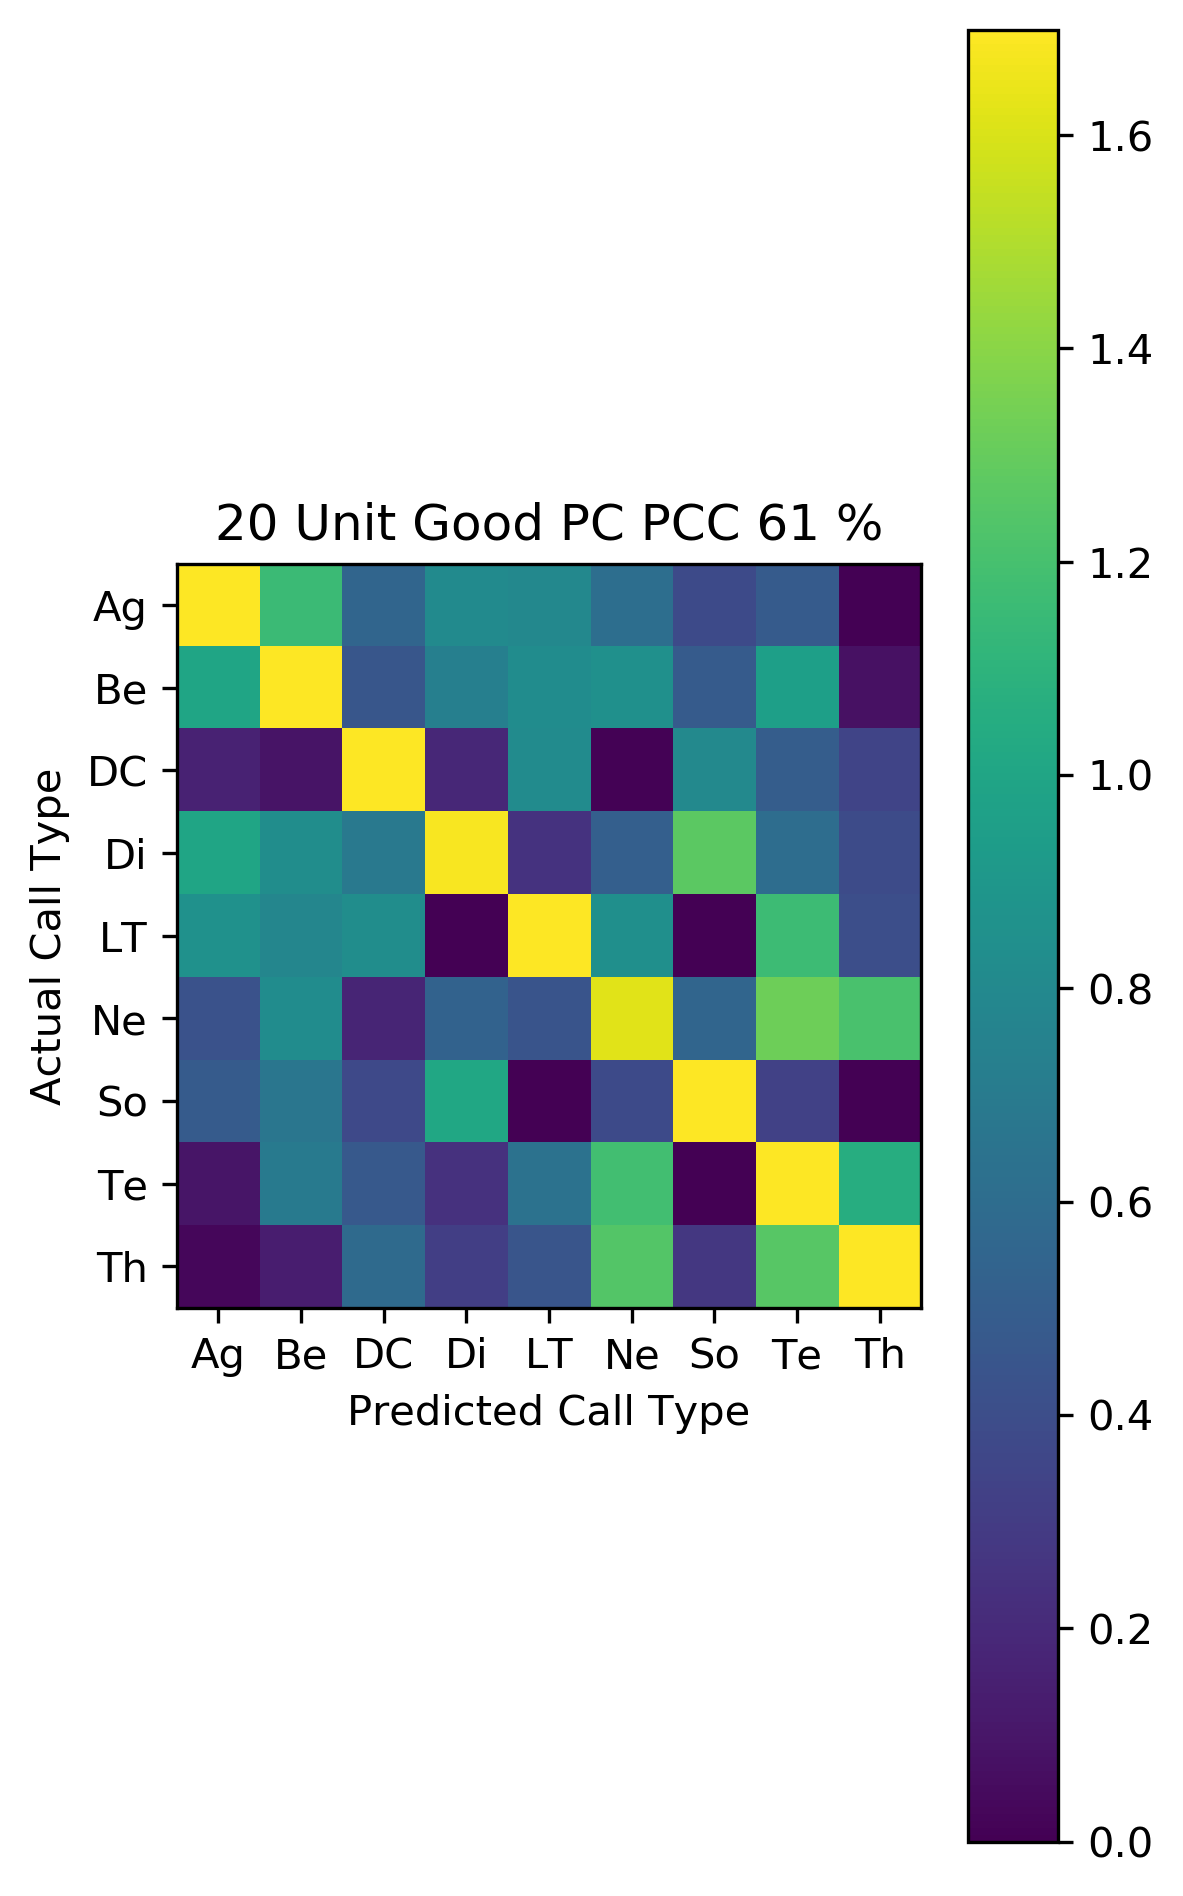

In [39]:
fig = plt.figure(figsize=(4,8), dpi=300)
ax = fig.subplots()
cmap='viridis'
ncalls = confMat[0].shape[0]
ind = 5

im_ = ax.imshow(np.log10(confMat[ind]*100.0), interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=np.log10(1), vmax = np.log10(50))

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%d Unit Good PC PCC %.0f %%' % (numUnits[ind], np.mean(pcc[ind])))


plt.savefig('/Users/frederictheunissen/Desktop/confMat20UnitGoodPCLogJulie.eps')


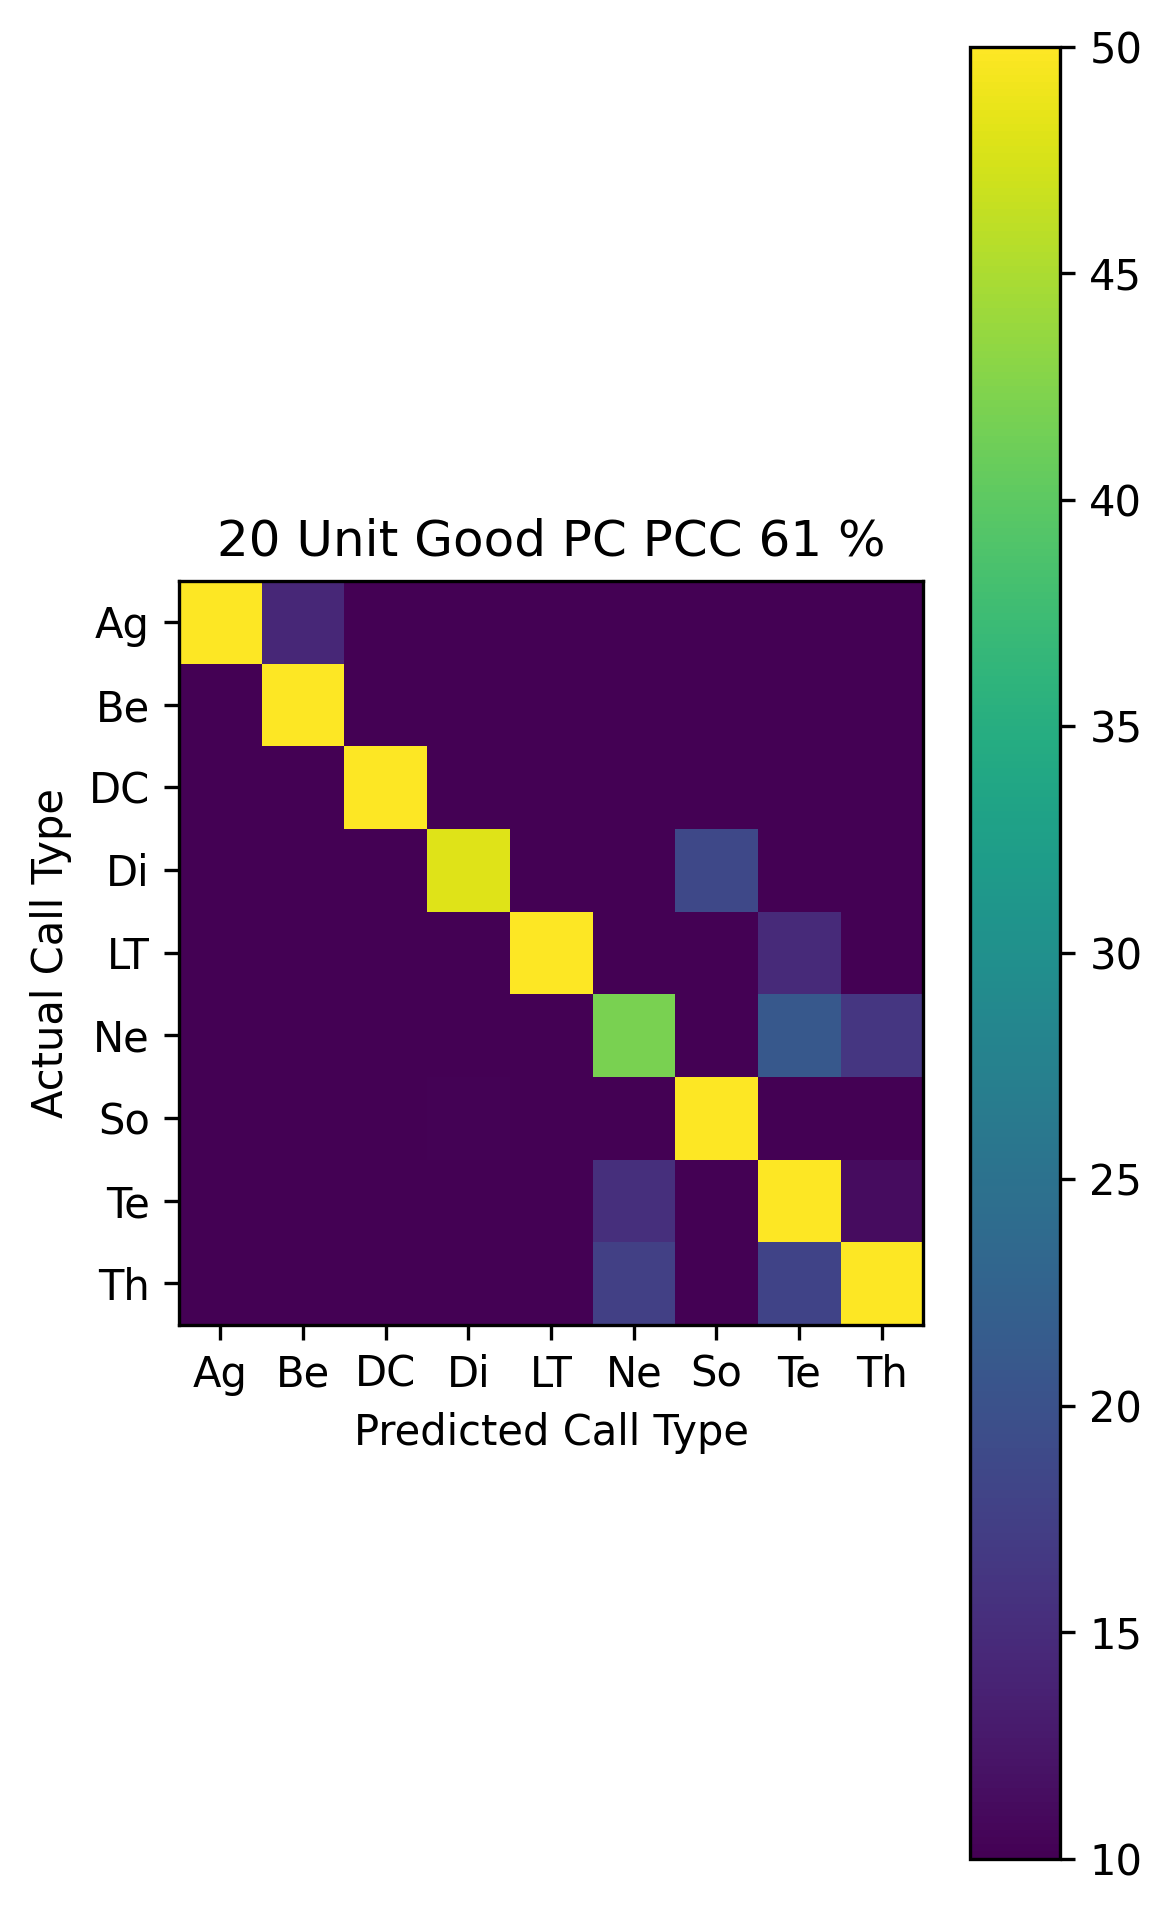

In [14]:
fig = plt.figure(figsize=(4,8), dpi=300)
ax = fig.subplots()
cmap='viridis'
ncalls = confMat[0].shape[0]
ind = 5

im_ = ax.imshow(confMat[ind]*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=10, vmax = 50)

fig.colorbar(im_, ax=ax)
ax.set(xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='%d Unit Good PC PCC %.0f %%' % (numUnits[ind], np.mean(pcc[ind])))


plt.savefig('/Users/frederictheunissen/Desktop/confMat20UnitGoodPCJulie.pdf')

NameError: name 'confMatMax' is not defined

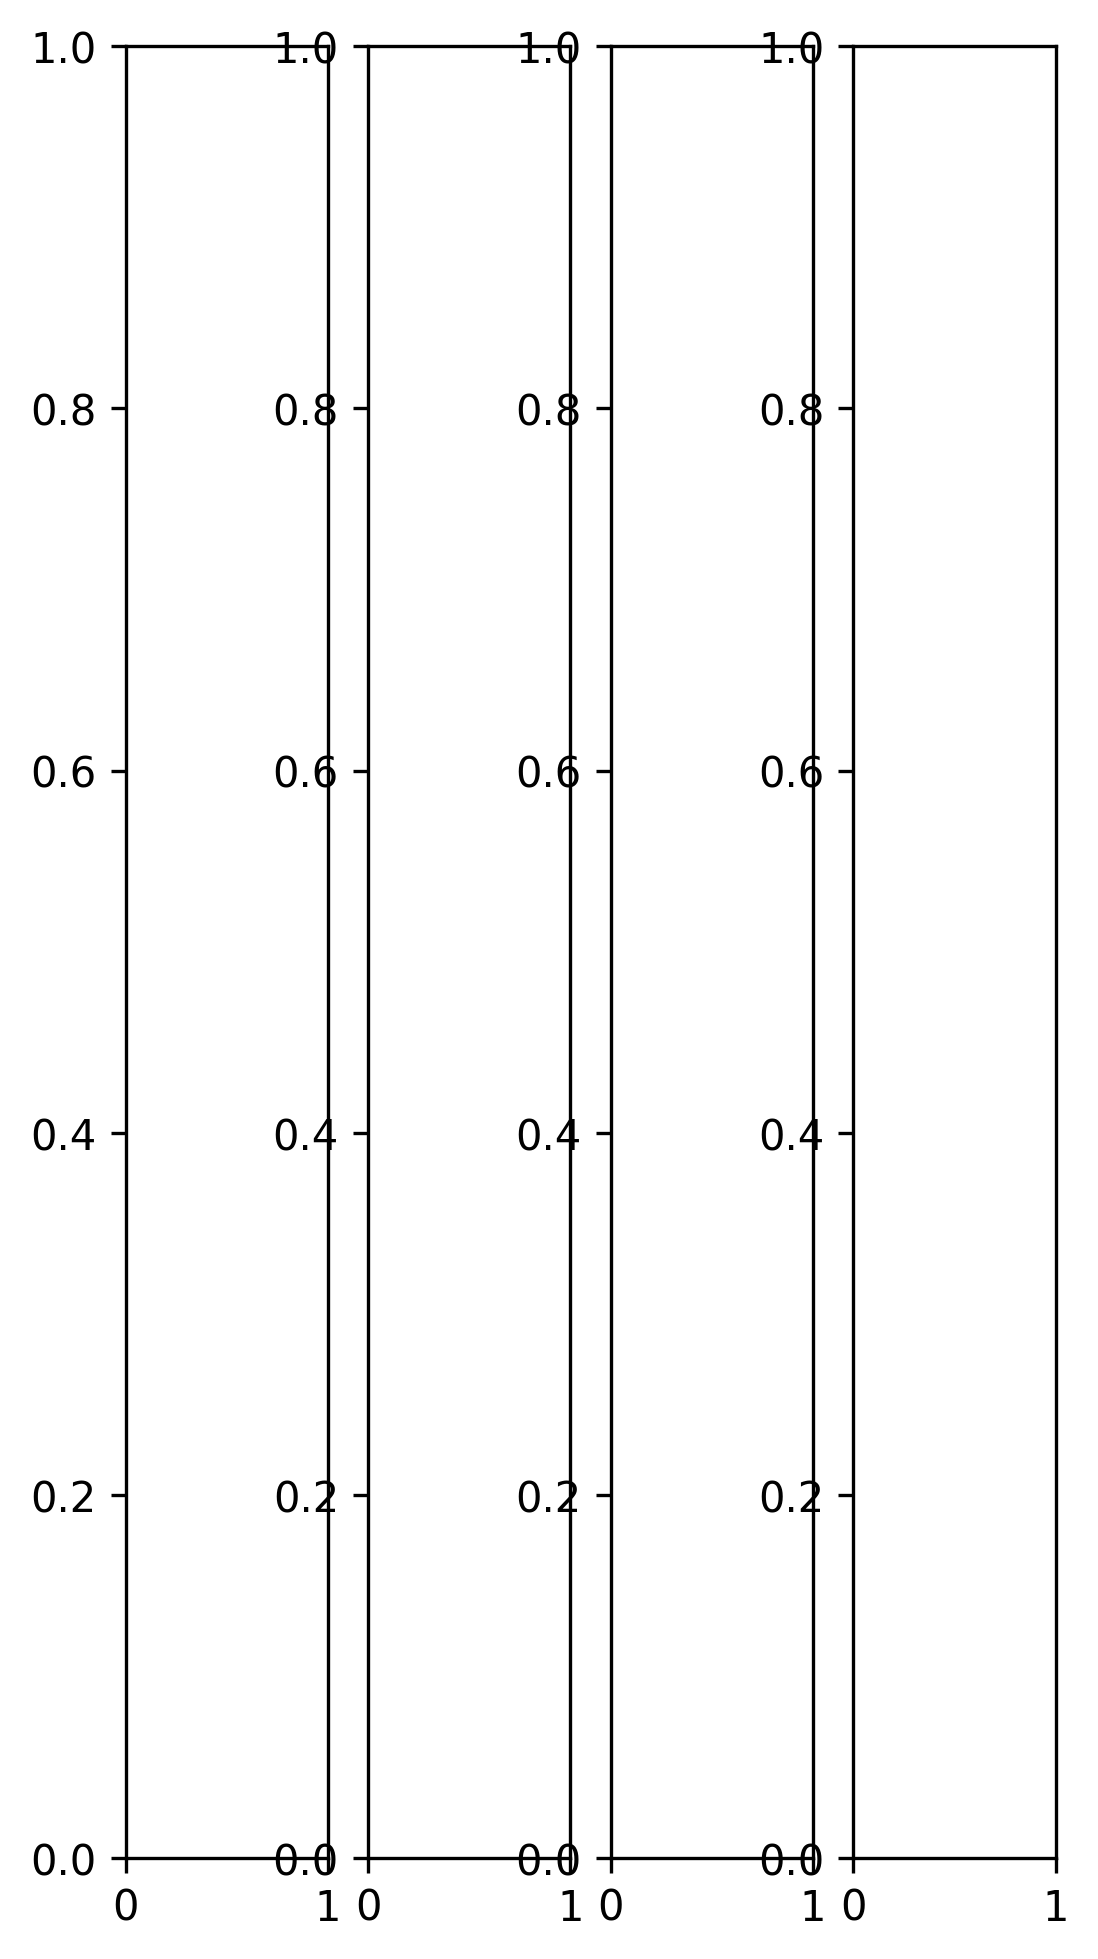

In [8]:
indToPlot = [0, 3, 4, 5]
fig = plt.figure(figsize=(4,8), dpi=300)
axes = fig.subplots( nrows = 1, ncols = len(indToPlot))
cmap='viridis'
ncalls = confMat[0].shape[0]

for i, ind in enumerate(indToPlot):    
    ax = axes[i]
    #im_ = ax.imshow(confMatMax[ind]*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=10, vmax = 50)
    im_ = ax.imshow(np.log10(confMatMax[ind]*100.0), interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=0, vmax = 1.5)

    ax.set(
               xticks=[],
               yticks=[],
               ylim = (ncalls-0.5, -0.5),
               xticklabels=[],
               yticklabels=[],
               # ylabel="Actual Call Type",
               # xlabel="Predicted Call Type",
               title='%d' % numUnits[ind] )

fig.colorbar(im_, ax=ax)
plt.savefig('/Users/frederictheunissen/Desktop/confMatAllUnitGoodPCMAXLogwScaleJulie.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


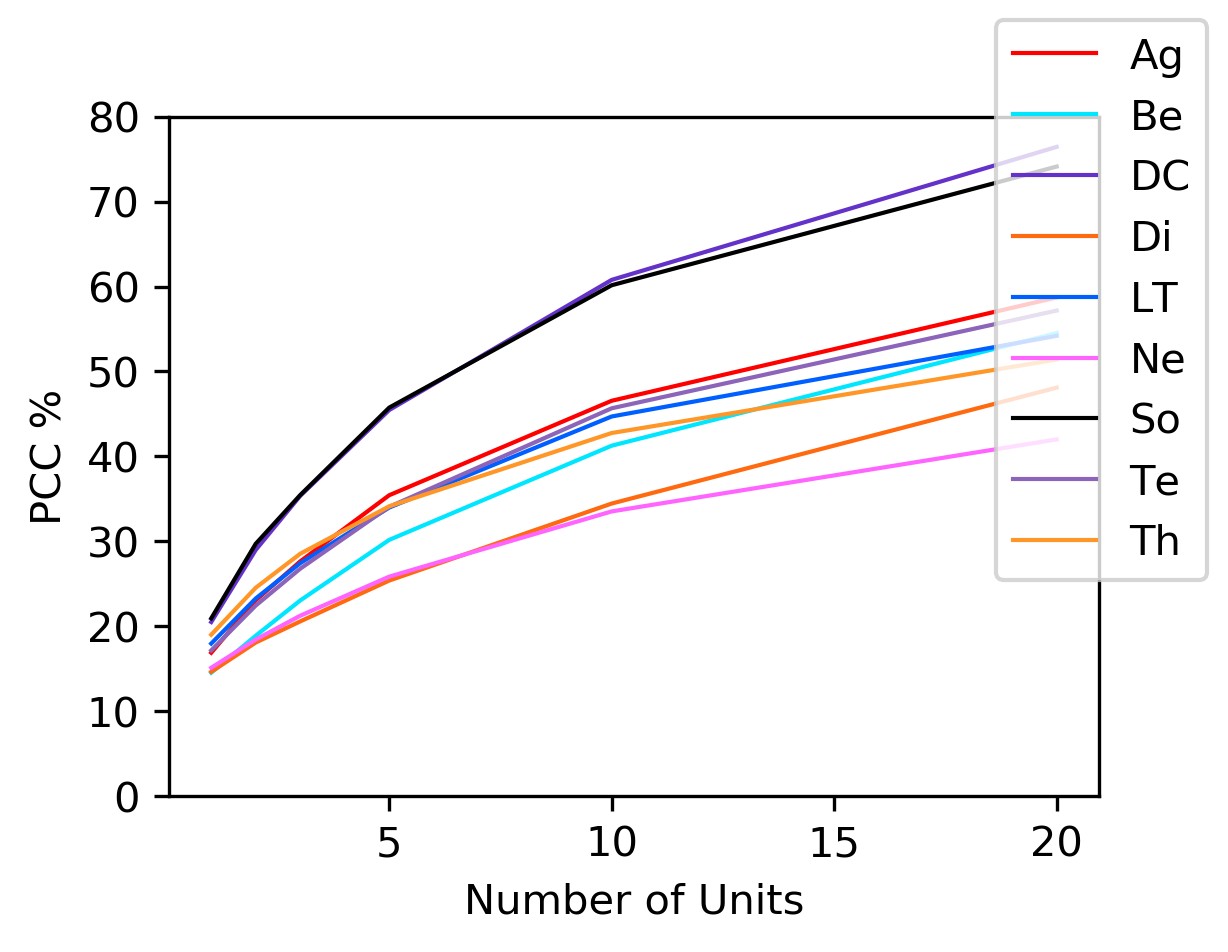

In [41]:
# Make plot of mean values
fig, ax1 = plt.subplots(figsize=(4, 3), dpi =300)

ax1.set_xlabel('Number of Units')
ax1.set_ylabel('PCC %')

for ic, call in enumerate(callNames):
    pccCall = np.zeros(len(numUnits))
    for iu, nUnit in enumerate(numUnits):
        pccCall[iu] = confMat[iu][ic,ic]*100.0        
    ax1.plot(numUnits, pccCall, color= callColor[call], linestyle='-', linewidth=1, label=call)

ax1.set_ylim((0,80))

fig.legend()


plt.savefig('/Users/frederictheunissen/Desktop/PCCvsUnitsperCallTypeJulie.eps')

In [43]:
# Set paths
#rootPathH = '/Users/frederictheunissen/Code/songephys/'
#dataPathH = 'data/birds/'

rootPathJ = '/Users/frederictheunissen/Google Drive/My Drive/julie/'
pklPathJ = 'pkl/'


# Read data files 
#inPathH = rootPathH+dataPathH+'summarySel.pkl'
#fileInH = open(inPathH,"rb")
#dfSummaryH = pk.load(fileInH)
#fileInH.close()

# Add a field called site_unit to match what is in argList
#dfSummaryH['site_unit'] = dfSummaryH['site']+ '_' + dfSummaryH['unit']

# Read data files 
inPathJ = rootPathJ+pklPathJ+'summarySelJulie.pkl'
fileInJ = open(inPathJ,"rb")
dfSummaryJ = pk.load(fileInJ)
fileInJ.close()

# Add a field called site_unit to match what is in argList
dfSummaryJ['site_unit'] = dfSummaryJ['site']+ '_' + dfSummaryJ['unit']

In [1]:
from random import sample

indToPlot = [0, 4, 5, 6]
fig = plt.figure(figsize=(4,12), dpi=300)
axes = fig.subplots( nrows = len(indToPlot), ncols = 1)


for i, ind in enumerate(indToPlot):    
    ax = axes[i]
    if (i == 0) :
        ax.scatter(pccValList[ind], selIndList[ind], s=1, color='grey', marker = ',')
    else:
        selInd = sample(range(len(pccValList[ind])), 1000)
        ax.scatter(pccValList[ind][selInd], selIndList[ind][selInd], s=1, color='grey', marker = ',')
        
    # fit a linear curve an estimate its y-values and their error.
    a, b = np.polyfit(pccValList[ind], selIndList[ind], deg=1)
    if "i == 0" :
        x = pccValList[ind]
        indSort = np.argsort(x)
        x = x[indSort]
        y = selIndList[ind][indSort]
    else:
        x = pccValList[ind][selInd]
        y = selIndList[ind][selInd]
        indSort = np.argsort(x)
        x = x[indSort]
        y = y[indSort]
    
    y_est = a * x + b
    y_err = x.std() * np.sqrt(1/len(x) +
                          (x - x.mean())**2 / np.sum((x - x.mean())**2))


    ax.plot(x, y_est, '-')
    ax.fill_between(x, y_est - y_err, y_est + y_err, alpha=0.2)

    ax.set(    xlim=(0,80),
               ylim=(0,1),
               ylabel="Sel Ind",
               title='%d' % numUnits[ind] )
    if (i == 3):
        ax.set(xlabel="PCC")

# fig.colorbar(im_, ax=ax)
plt.savefig('/Users/frederictheunissen/Desktop/scatterSelPCC.png')

NameError: name 'plt' is not defined

In [11]:
## Read the values obtained from the entire data base for 1 unit to make matched histograms and confusion mat

inPath = rootPath+ dataPath + 'HerminaDataBase1Unitz.pkl' 
fileIn = open(inPath,"rb")
unitNameZ = pk.load(fileIn)
confMatZ = pk.load(fileIn)
pccZ = pk.load(fileIn)
fileIn.close()

inPath = rootPath+ dataPath + 'HerminaDataBase1UnitPC.pkl' 
fileIn = open(inPath,"rb")
unitNamePC = pk.load(fileIn)
confMatPC = pk.load(fileIn)
pccPC = pk.load(fileIn)
fileIn.close()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


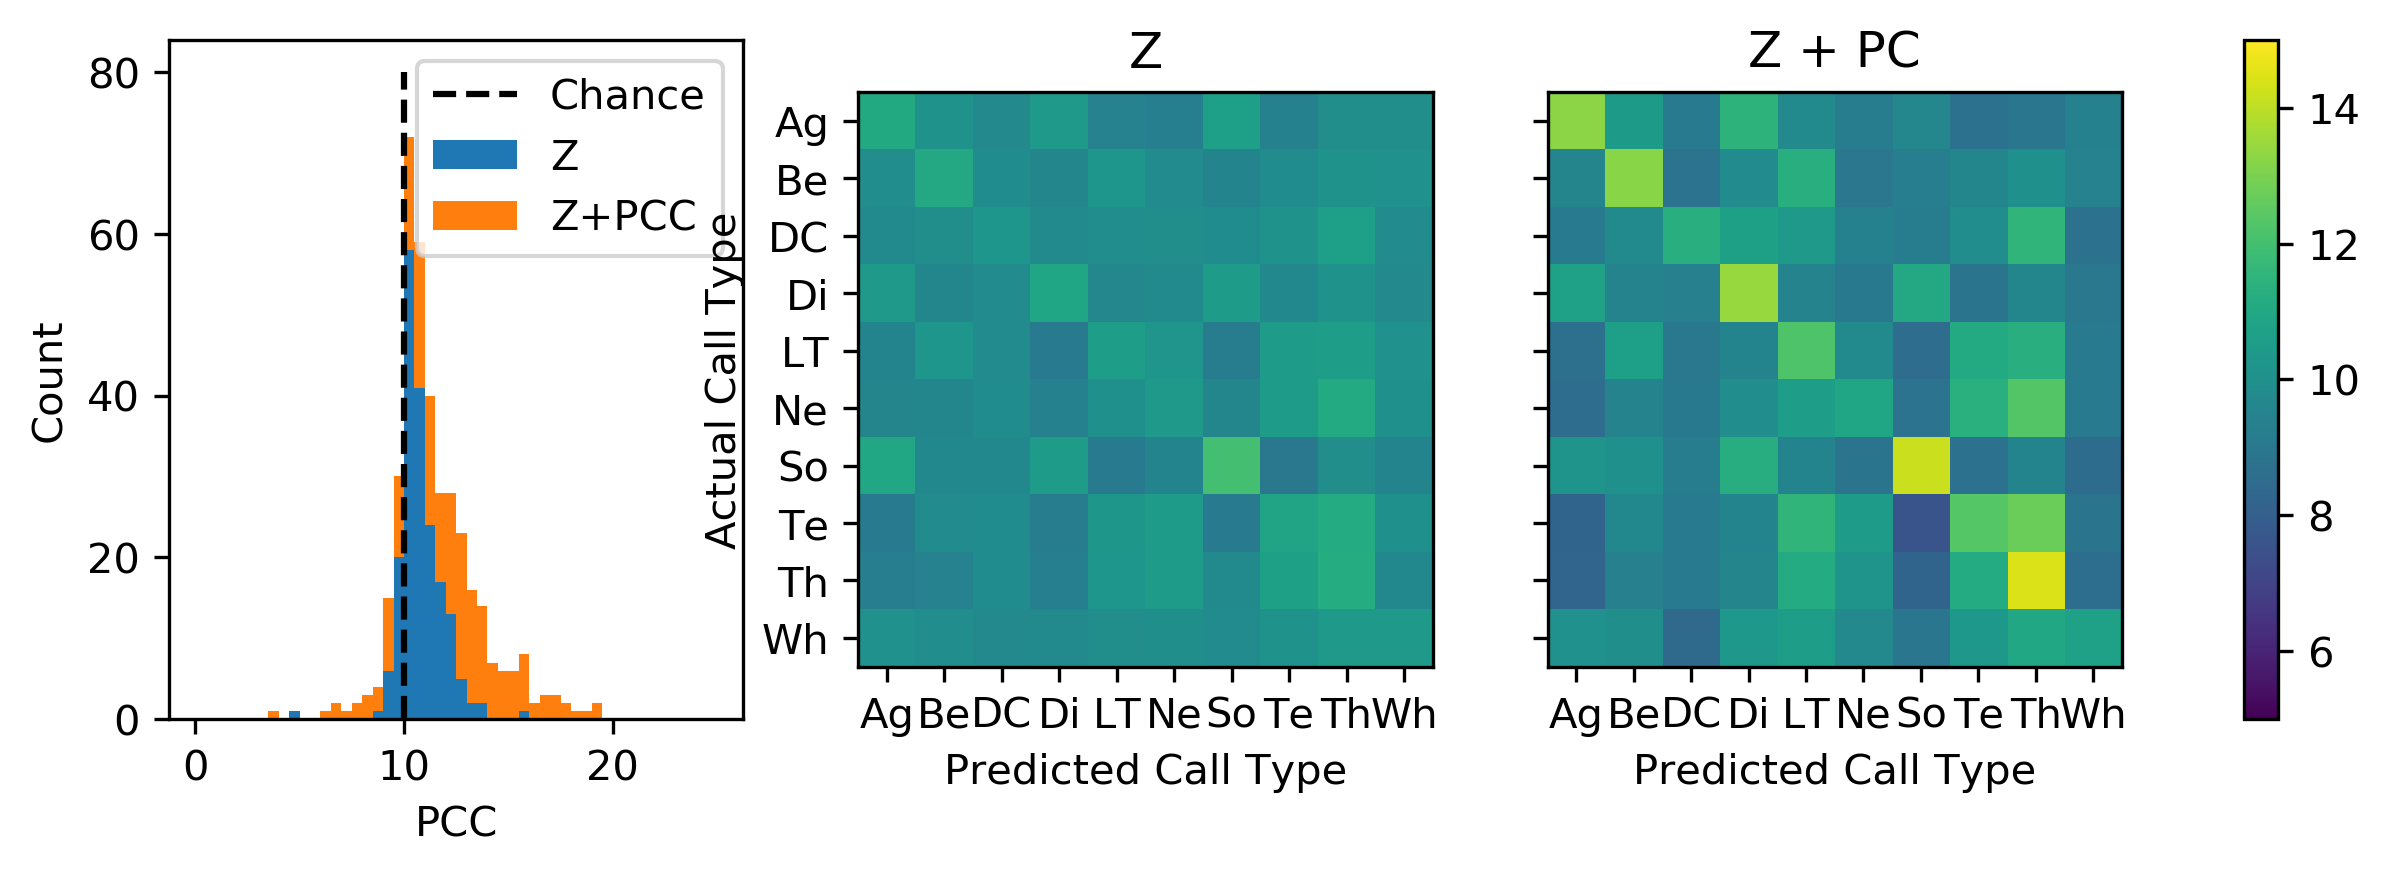

In [34]:
fig = plt.figure(figsize=(10.5,3), dpi=300)
ax = fig.subplots(nrows=1, ncols=3)
cmap='viridis'

ax[0].hist([pccZ, pccPC], bins = 50, range = (0,25), stacked=True)
ax[0].plot([10, 10], [0,80], '--', color='black')
ax[0].set_xlabel('PCC')
ax[0].set_ylabel('Count')
ax[0].legend(['Chance', 'Z','Z+PCC'])

im_ = ax[1].imshow(confMatZ*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 15)

ax[1].set(
               xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=callNames,
               ylabel="Actual Call Type",
               xlabel="Predicted Call Type",
               title='Z' )

im_ = ax[2].imshow(confMatPC*100.0, interpolation='nearest', cmap=cmap, extent = (-0.5, ncalls-0.5, ncalls-0.5, -0.5), vmin=5, vmax = 15)

ax[2].set(
               xticks=np.arange(ncalls),
               yticks=np.arange(ncalls),
               ylim = (ncalls-0.5, -0.5),
               xticklabels=callNames,
               yticklabels=[],
               ylabel=None,
               xlabel="Predicted Call Type",
               title='Z + PC' )

fig.colorbar(im_, ax=ax)


plt.savefig('/Users/frederictheunissen/Desktop/pcchist1UnitFULLZvsPCwScale.eps')

In [42]:
len(np.linspace(-500, 499, 1000))

1000

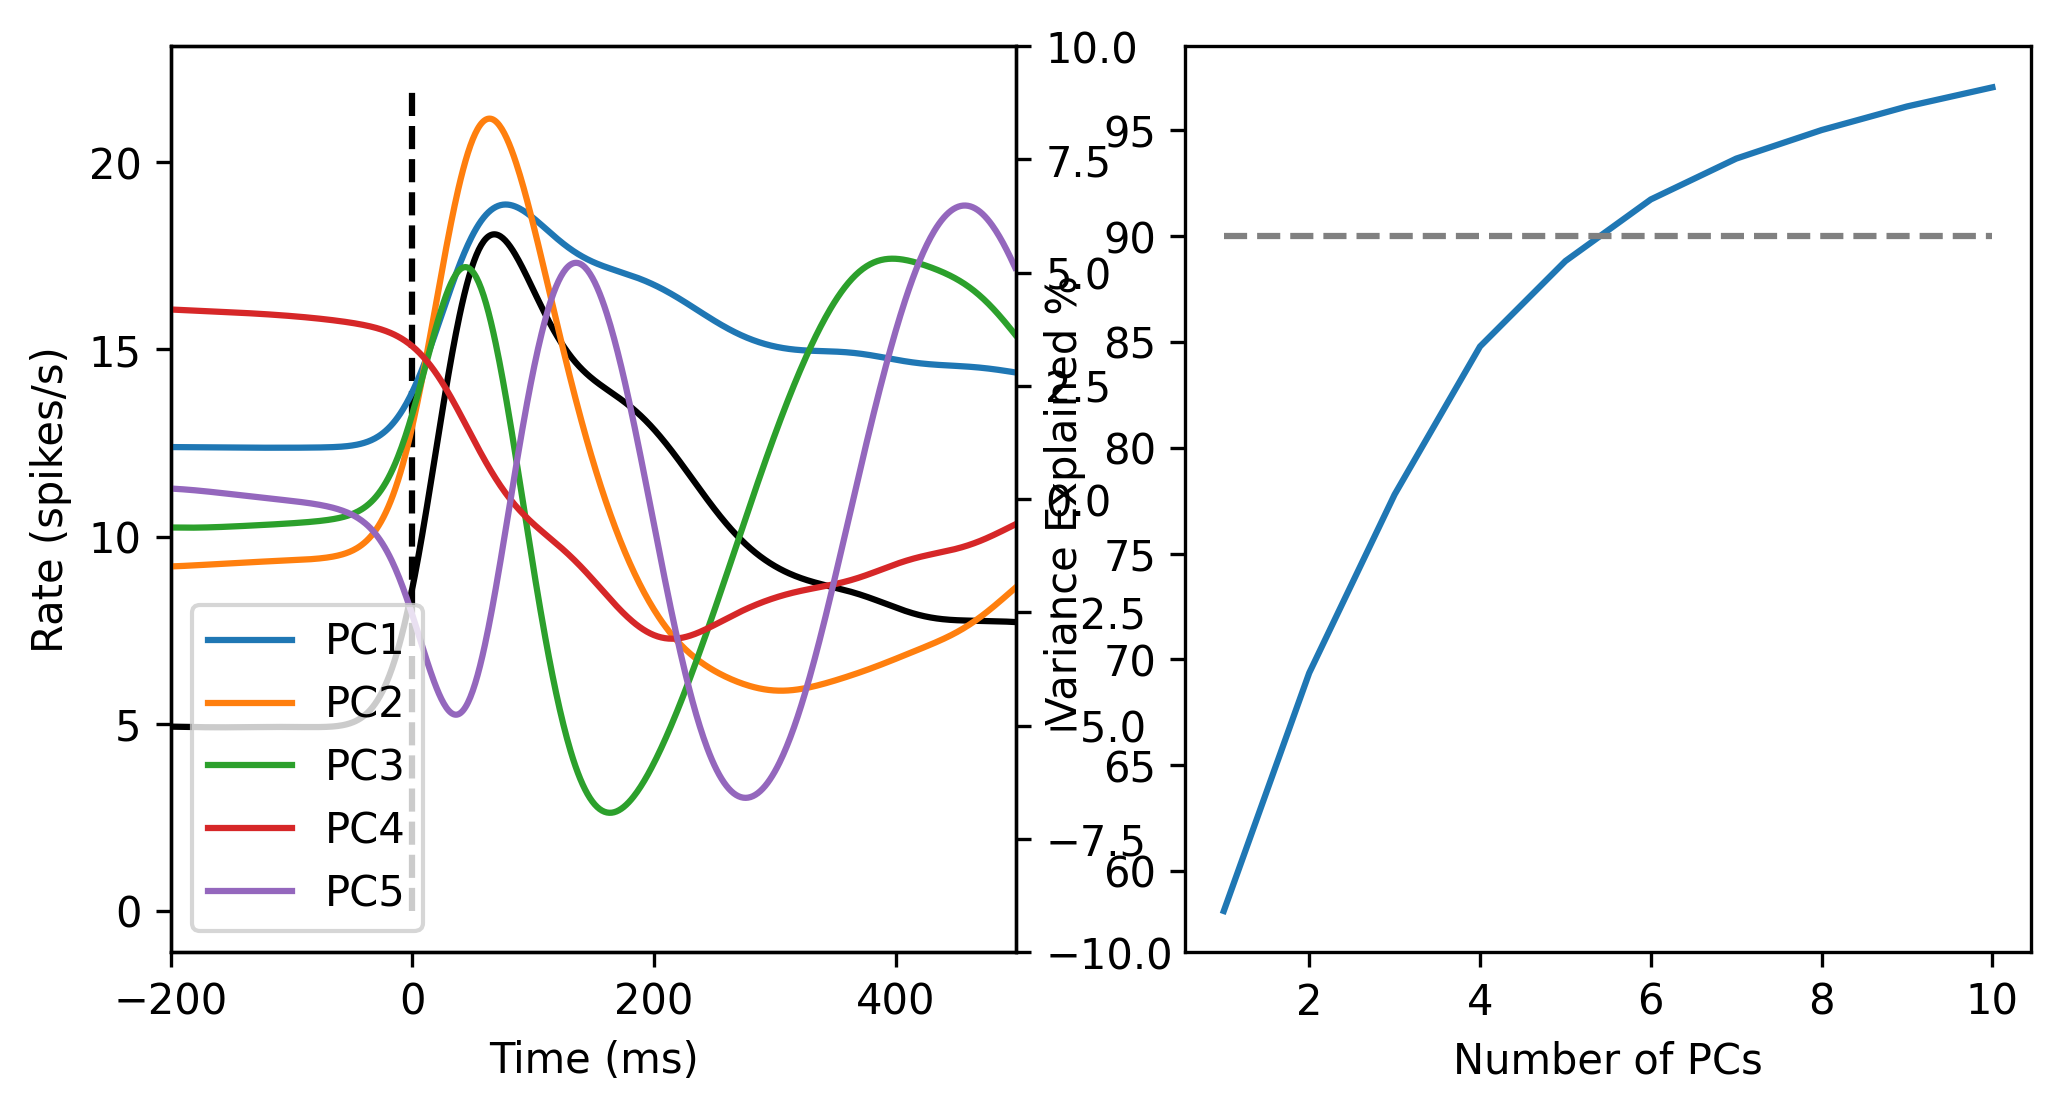

In [5]:
fig = plt.figure(figsize=(8,4), dpi = 300)
ax = fig.subplots(nrows=1, ncols=2)
t = np.linspace(-500, 499, 1000)

ax[0].plot(t, pcKDE.mean_, label='Mean', color = 'black')
ax[0].plot([0, 0], [0,22], '--', color = 'black')
ax[0].set( xlabel = 'Time (ms)', ylabel = 'Rate (spikes/s)' , xlim=(-200, 500))


ax2 = ax[0].twinx()
ax2.plot(t, pcKDE.components_[0,:]*100, label='PC1')
ax2.plot(t, pcKDE.components_[1,:]*100, label='PC2')
ax2.plot(t, pcKDE.components_[2,:]*100, label='PC3')
ax2.plot(t, pcKDE.components_[3,:]*100, label='PC4')
ax2.plot(t, pcKDE.components_[4,:]*100, label='PC5')
ax2.set( ylim = (-10,10))


ax2.legend()

ax[1].plot(np.linspace(1,10, num=10), np.cumsum(pcKDE.explained_variance_ratio_)*100)
ax[1].plot( [1, 10], [90, 90], '--', color = 'grey')
ax[1].set ( xlabel = 'Number of PCs', ylabel = 'Variance Explained %' )

plt.savefig('/Users/frederictheunissen/Desktop/PCAVarianceExplainedJulie.pdf')